# Aiyagari Models
<style type="text/css">
  .reveal p {
    text-align: left;
  }
  .reveal ul {
    display: block;
  }
  .reveal ol {
    display: block;
  }
</style>
# Consumption Savings Problem
## Overview
* Bewely/Hugget/Aiyagari style models are the workhorse models of heterogeneous agent macro

* Generally feature a standard production side with a representative firm
    * though this can be relaxed

* Household side features agents who face income risk
    * fluctuations in labor productivity
    * imcomplete markets (trade risk free bond)

* Focus on steady state
    * constant interest rate and wages
    * stationary distribution of wealth

## The Household Problem
* Assume a unit mass of households 

* Households differ in
    * their current wealth position, $a_{i,t}$
    * their labor productivity, $\epsilon_{i,t}$

* Assume that labor productivity follows a finite state Makov process
    * transition matrix $\Pi$

* Payed a wage rate $\bar w$ per unit of effective labor
    * total income $\bar w\epsilon_{i,t}$

* Have the ability save with a bond
    * risk free interest rate $\bar r$
    * up to borrowing constraint $\underline a$

## Bellman Equation
* Let $V(a,s)$ be the value to the household of entering the period
    * with wealth $a$
    * current labor productivity $\epsilon_s$

* The HH value equation solves the following Bellman equation
$$
    V(a,s) = \max_{c,a'} u(c) + \beta \sum_{s'} \Pi(s'|s)V(a',s')
$$
subject to 
$$
    c + a' = (1+\bar r) a + \bar w \epsilon_s 
$$
and 
$$
    a'\geq \underline a
$$
* Can approach this using standard methods

## The HH Problem

In [1]:
using BasisMatrices,LinearAlgebra,Parameters,Optim,QuantEcon,DataFrames,Gadfly,SparseArrays,Arpack
using Roots
@with_kw mutable struct HHModel
    #Preference Parameters
    γ::Float64 = 1. #Risk aversion
    β::Float64 = 0.985 #Discount Rate

    #Prices
    r̄::Float64 = .01
    w̄::Float64 = 1.

    #Asset Grid Parameters
    a̲::Float64 = 0. #Borrowing Constraint
    a̅::Float64 = 600. #Upper Bound on assets
    Na::Int64 = 100 #Number of grid points for splines

    #Income Process
    ρ_ϵ::Float64 = 0.9923
    σ_ϵ::Float64 = 0.0983
    Nϵ::Int64 = 7
    ϵ::Vector{Float64} = zeros(0)
    Π::Matrix{Float64} = zeros(0,0)

    #Solution
    k::Int = 2 #type of interpolation
    Vf::Vector{Interpoland} = Interpoland[]
    cf::Vector{Interpoland} = Interpoland[]

    #Extra
    EΦ′::SparseMatrixCSC{Float64,Int64} = spzeros(0,0)
    Φ::SparseMatrixCSC{Float64,Int64} = spzeros(0,0)
end;

## Some Setup

In [2]:
"""
    U(HH::HHModel,c)
"""
function U(HH::HHModel,c)
    γ = HH.γ
    if γ == 1
        return log.(c)
    else
        return (c.^(1-γ))./(1-γ)
    end
end

"""
    setupgrids_shocks!(HH::HHModel, curv=1.7)

Set up non-linear grids for interpolation
"""
function setupgrids_shocks!(HH::HHModel, curv=1.7)
    @unpack a̲,a̅,Na,ρ_ϵ,σ_ϵ,Nϵ,k,r̄,w̄,β = HH
    #Compute grid on A
    agrid = (a̅-a̲).*LinRange(0,1,Na).^curv .+ a̲

    #Store markov chain
    mc = rouwenhorst(Nϵ,ρ_ϵ,σ_ϵ)
    HH.Π = Π = mc.p
    HH.ϵ = exp.(mc.state_values)

    #First guess of interpolation functions
    abasis = Basis(SplineParams(agrid,0,k))
    a = nodes(abasis)[1]

    Vf = HH.Vf = Vector{Interpoland}(undef,Nϵ)
    cf = HH.cf = Vector{Interpoland}(undef,Nϵ)
    for s in 1:Nϵ
        c = @. r̄*a + w̄*HH.ϵ[s]
        V = U(HH,c)./(1-β)

        Vf[s]= Interpoland(abasis,V)
        cf[s]= Interpoland(abasis,c)
    end
end;

## Solving For Optimal Policy

In [3]:
"""
    optimalPolicy(HH,Vf′)

Computes the  optimalPolicy given value function Vf′ if the state is (a,i)
"""
function optimalPolicy(HH,a,s,Vf′)
    @unpack a̲,a̅,β,Π,ϵ,r̄,w̄,Nϵ = HH 

    function objf(a′)
        c = (1+r̄)*a + ϵ[s]*w̄ - a′
        return U(HH,c) + β*sum(Π[s,s′]*Vf′[s′](a′) for s′ in 1:Nϵ)
    end
    a_max = min((1+r̄)*a+ϵ[s]*w̄,a̅)
    res = maximize(objf,a̲,a_max)
    a′ = Optim.maximizer(res)
    #return value and consumption that optimize
    return (V=objf(a′),c=(1+r̄)*a + ϵ[s]*w̄ - a′)
end;

## Iterating on Bellman Equation

In [4]:
"""
    iterateBellman(HH,Vf′)

Iterates the Bellman equation given value function Vf′
"""
function iterateBellman(HH,Vf′)
    Nϵ = length(Vf′)
    Vf = Vector{Interpoland}(undef,length(Vf′))

    for s in 1:Nϵ
        basis = Vf′[s].basis
        V = [optimalPolicy(HH,a,s,Vf′).V for a in nodes(basis)[1]]
        Vf[s]= Interpoland(basis,V)
    end

    return Vf
end;

## Solving the Bellman Equation

In [5]:
"""
    solveBellman!(HH)
Solves the Bellman Equation for the HH problem
"""
function solveBellman!(HH)
    Nϵ = HH.Nϵ
    diff = 1.
    Vf′ = copy(HH.Vf)
    while diff > 1e-8 
        HH.Vf = iterateBellman(HH,Vf′)
        diff = maximum([norm(Vf′[s].coefs - HH.Vf[s].coefs,Inf) for s in 1:Nϵ])
        println(diff)
        Vf′ = HH.Vf
    end
end;

## Problem
* This takes a while

In [6]:
HH = HHModel()
setupgrids_shocks!(HH)
iterateBellman(HH,HH.Vf)
@time iterateBellman(HH,HH.Vf);

  0.356208 seconds (4.57 M allocations: 371.497 MiB, 22.72% gc time)


* Solving the full bellman equation takes 5-10 minutes

* Why is it taking so long?
    * We can use profiling to figure it out

## Profiling

In [7]:
#@profview iterateBellman(HH,HH.Vf);

* Can't get output to show up here :(

* All of the time is spent maximizing 
    * Can we sepped this up

## Endogenous Grid 
* A clever solution to this problem is the endogenous grid method Carroll (2005)
    * trick is to solve for policy functions directly
    * use interpolation instead of root solving

* Let $c(a,s)$ and $a'(a,s)$ be the consumption and asset policies that solves the HH problem

* They must satify
$$
    c(a,s) + a'(a,s) = (1+\bar r)a + \epsilon_s\bar w
$$
and 
$$
    U'(c(a,s)) \geq \beta(1+\bar r)\sum_{s'}\Pi(s'|s) U'(c(a'(a,s),s'))
$$
with strict inequality only if 
$$
    a'(a,s) = \underline a
$$

## Endogenous Grid Continued
* Instead of specifying on $a$ we'll specify a grid on $a'$
    * let $\underline a =\bar a'_1$, $\bar a'_2$, $\ldots$, $\bar a'_n$ be a grid on future assets

* Given function, $\tilde c(a',s')$, for consumption next period

* The expected marginal utility of consumption next period for wealth level $\bar a'_i$ and current productivity $\epsilon_s$ 
$$
    \sum_{s'}\Pi(s'|s) U'(\tilde c(\bar a'_i,s'))
$$

* If the agent is on their euler equation then consumption his period is
$$
\bar c_{i,s} =  {U'}^{-1}\left(\beta(1+\bar r)\sum_{s'}\Pi(s'|s) U'(\tilde c(\bar a'_i,\epsilon_{s'}))\right)
$$

## Endogenous Grid Continued
* The wealth position that corresponds to this consumption choice satisfies
$$
    (1+\bar r)\bar a_{i,s} = \bar c_{i,s} +\bar a'_i - \bar w \epsilon_s
$$

* We now have a grid of assets $\bar a_{i,s}$ for each productivity $\epsilon_s$
    * and a corresponding consumption choice $\bar c_{i,s}$
    * grid points are endogenous
    * can interpolate to find optimal consumption everywhere

* This only works if Euler equation holds with equality
    * if $\bar a_{1,s} > \underline a$ then borrowing constraint binds for this productivity
    * add another gridpoint at $\underline a$ with consumption $\bar r \underline a + w\bar \epsilon_s$

* Keep iterating until policy rules converge

## Endogneous grid Implementation

In [8]:
"""
    iterate_endogenousgrid(HH,a′grid,cf′)

Iterates on Euler equation using endogenous grid method
"""
function iterate_endogenousgrid(HH,a′grid,cf′)
    @unpack γ,ϵ,β,Nϵ,Π,r̄,w̄,a̲= HH
    c′ = zeros(length(a′grid),Nϵ)
    for s in 1:Nϵ
        c′[:,s]= cf′[s](a′grid)
    end

    EERHS = β*(1+r̄)*(c′).^(-γ)*Π' #RHS of Euler Equation
    c = EERHS.^(-1/γ)

    #compute implies assets
    a = ((c .+ a′grid) .- w̄ .*ϵ')./(1+r̄)

    cf = Vector{Interpoland}(undef,Nϵ)
    for s in 1:Nϵ
        if a[1,s]> a̲
            c̲ = r̄*a̲ + w̄*ϵ[s]
            cf[s]= Interpoland(Basis(SplineParams([a̲; a[:,s]],0,1)),[c̲;c[:,s]])
        else
            cf[s]= Interpoland(Basis(SplineParams(a[:,s],0,1)),c[:,s])
        end
    end
    return cf
end;

## Solving HH Problem with Endogenous Grid

In [9]:
"""
    solveHHproblem_eg!(HH)

Solves the HH problem using the endogeneous grid method
"""
function solveHHproblem_eg!(HH,verbose=false)
    a′grid = nodes(HH.cf[1].basis)[1]#Get nodes for interpolation
    
    cf′ = iterate_endogenousgrid(HH,a′grid,HH.cf)
    diff = 1.
    while diff  > 1e-8
        HH.cf = iterate_endogenousgrid(HH,a′grid,cf′)
        diff = maximum(norm(cf′[s](a′grid)-HH.cf[s](a′grid),Inf) for s in 1:HH.Nϵ) 
        if verbose
            println(diff)
        end
        cf′ = HH.cf
    end
end
solveHHproblem_eg!(HH)
setupgrids_shocks!(HH)
@time solveHHproblem_eg!(HH);

  0.534159 seconds (1.39 M allocations: 868.108 MiB, 11.56% gc time)


# Euler Equation Errors
## How To Measure Accuracy
* A constant problem we encounter is how to measure the accuracy of a solution

* In the economy each constraint is only approximately satisfied
    * how big is an error?  What does $1e-6$ mean?

* We'll use the Euler equation as an example
$$
    c_{i,t}^{-\sigma} = \beta (1+\bar r)\mathbb E_t\left[c_{i,t+1}^{-\sigma}\right]
$$

* Want to have an economically interpretable measure of errors in this equation

## Euler Equation Errors
* Let $c(a,s)$ be a candidate for the optimal consumption function

* Can compute implies savings function $a'(a,s) = (1+\bar r) a + \bar w \epsilon_s - c'(a,s)$

* For a given state $(a,s)$ compute the RHS of the Euler equation that would prevail under these rules
$$
    \sum_{s'}\Pi(s'|s)c(a'(a,s),s')^{-\sigma}
$$

* Compute the implies consumption that satisfies the Euler Equation
$$
    \hat c(a,s) = \left(\sum_{s'}\Pi(s'|s)c(a'(a,s),s')^{-\sigma}\right)^{-1/\sigma}
$$

* Compute the error in units of log base 10
$$
    \log_{10}\left(\frac{|c(a,s)-\hat c(a,s)|}{\hat c(a,s)}\right)
$$


## How Big Should These Errors Be?

* Generally want to take the max over the sate space

* Generally want errors on the order of -3
    * Represents an error on the order of 1 in 1000
    * For a person making $50,000 that's an error of $50 over a year

## Implementating EE Errors

In [10]:
"""
    ee_errors(HH,agrid) 

Check's the Euler equation errors of a solution on a grid of assets
"""
function ee_errors(HH,agrid)
    @unpack cf,γ,β,ϵ,Π,Nϵ,r̄,w̄,a̲ = HH
    
    EE = zeros(length(agrid),Nϵ)
    for s in 1:Nϵ
        c = cf[s](agrid)
        a′ = @. (1+r̄)*agrid + w̄*ϵ[s]- c
        c′ = hcat([cf[s′](a′) for s′ in 1:Nϵ]...)
        ĉ  = (β.*(1+r̄).*c′.^(-γ)*Π[s,:]).^(-1/γ)
        EE[:,s]= log10.(abs.(ĉ.-c)./ĉ)
        EE[abs.(a′.-a̲).<1e-4,s].= -6 #record a small error when on borrowing constraints
    end

    df = DataFrame(EE,["ϵ_$s" for s in 1:Nϵ])
    df.a = agrid
    return df,maximum(EE)
end;

## Our EE Errors

-3.327190685133876


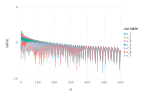

In [11]:
HH.Na = 100
setupgrids_shocks!(HH,3.)
solveHHproblem_eg!(HH)
agrid = LinRange(HH.a̲,HH.a̅,1000)
df_ee,EEmax = ee_errors(HH,agrid)
println(EEmax)
plot(stack(df_ee,["ϵ_$s" for s in 1:HH.Nϵ]),x=:a,y=:value,color=:variable,Geom.line)

# Collocation
* There is one last tool we can use to speed up our solution of the HH problem

* Running the endogenous grid code, the policy rules take many iterations to converge

In [12]:
setupgrids_shocks!(HH,3.)
solveHHproblem_eg!(HH,true)

0.10442668007741585
0.10017431538841404
0.09607003621542987
0.09210976760802403
0.08828960545257925
0.08460571831883712
0.08105458460341541
0.07763268522944511
0.07433654334489237
0.0711629900360915
0.06810880760035687
0.06517052896213826
0.0623447095010512
0.059629322059181256
0.05701971969338704
0.05451333240247891
0.05210701853009869
0.04979747093503306
0.047581685020938735
0.04545649796414697
0.043419058778709996
0.041465590000054675
0.03959363644595282
0.037799837356925714
0.03608196620421822
0.03443610504119299
0.032859907192747784
0.03220006031586564
0.031934416677794175
0.03166848043804649
0.03140231317267883
0.031135975667089255
0.030869527890471815
0.030603028971899704
0.03033653717795559
0.030070109891866537
0.02980380359418966
0.029537673844895806
0.029271775266911604
0.02900682620284467
0.028752866363677576
0.028498823960489084
0.028244761445365363
0.02799074011992797
0.02773682012452916
0.02748306042860449
0.0272295188222742
0.026976251908997995
0.026723315099452805
0.026

* Can we reduce the number of iterations

## Newton's Method for the Bellman Equation
* Let $(\bar a_i,s_i)$ be the nodes on which the value function is interpolated
    * $i$ runs from $1$ to $N$ and indexes both the asset grid and the productivity grid

* Let $\phi_j(a,s)$ be the basis functions
    * let $\varphi_i$ be the coefficients on the basis functions that define $V$

* The bellman equation can be written as a system of $N$ equations and $N$ unkowns

* Let $F_i(\varphi)$ be the residual of the bellman equation for state $i$
$$
    F_i(\varphi) = \sum_j\varphi_j\phi_j(\bar a_i,s_i) -\left( \max_{c,a'} U(c) + \beta \sum_{s'}\Pi(s'|s_i)\sum_{j}\varphi_j\phi_j(a',s')\right)
$$
subject to
$$
c + a' = (1+\bar r)\bar a_i + \bar w_{s_i} 
$$and $a'\geq \underline a$.
* Solving the Bellman equation is finding the root of $F(\varphi)$

## Newton's method
* Were going to solve this using Newton's methods

* Start with a guess $\varphi^0$
    * Compute $F(\varphi^0)$
    * Compute the jacobian $DF(\varphi^0)$
    * Update guess $\varphi^1 = \varphi^0 - DF(\varphi^0)^{-1}F(\varphi^0)$

* Repeat to get a sequence $\{\varphi^n\}$ which converges to solution $\varphi$

* Our first order of business is to find functions $c(a,s;\varphi)$ and $a'(a,s;\varphi)$
    * that solve the max in $F$

* Can be done using endogenous grid method

## Endogneous grid method again
* Let $\bar a'_j$ be a grid on $a'$

* If the agent is not borrowing constrained then optimal consumption satisfies
$$
U'(\bar c_{j,s}) = \beta \sum_{s'}\Pi(s'|s)\sum_{j}\varphi_j\phi_j'(\bar a'_j,s')
$$

* Even better can precompute $\Pi(s'|s)\phi_j'(\bar a'_j,s')$ and store it in a matrix $E\Phi'$ so that
$$
    U'(\bar c) =\beta E\Phi'\varphi
$$

* Once $\bar c_{j,s}$ is computed we can compute $\bar a_{j,s}$ that satisfies
$$
    (1+\bar r) \bar a_{j,s} = \bar c_{j,s} +\bar a_{j}' - \bar w \epsilon_s
$$

* Interpolate to apply endogenous grid algorith
    * carefule to include borrowing constraint

## Computing E$\Phi'$

In [13]:
"""
    setupgrids_shocks!(HH::HHModel, curv=1.7)

Set up non-linear grids for interpolation
"""
function setupgrids_shocks!(HH::HHModel, curv=1.7)
    @unpack a̲,a̅,Na,ρ_ϵ,σ_ϵ,Nϵ,k,r̄,w̄,β = HH
    #Compute grid on A
    agrid = (a̅-a̲).*LinRange(0,1,Na).^curv .+ a̲

    #Store markov chain
    mc = rouwenhorst(Nϵ,ρ_ϵ,σ_ϵ)
    HH.Π = Π = mc.p
    HH.ϵ = exp.(mc.state_values)

    #First guess of interpolation functions
    abasis = Basis(SplineParams(agrid,0,k))
    a = nodes(abasis)[1]

    Vf = HH.Vf = Vector{Interpoland}(undef,Nϵ)
    cf = HH.cf = Vector{Interpoland}(undef,Nϵ)
    for s in 1:Nϵ
        c = @. r̄*a + w̄*HH.ϵ[s]
        V = U(HH,c)./(1-β)

        Vf[s]= Interpoland(abasis,V)
        cf[s]= Interpoland(abasis,c)
    end

    #Expectations of 1st derivative of Basis functions
    HH.EΦ′ = kron(Π,BasisMatrix(abasis,Direct(),nodes(abasis)[1],[1]).vals[1])
    HH.Φ = kron(Matrix{Float64}(I,Nϵ,Nϵ),BasisMatrix(abasis,Direct()).vals[1])
end

setupgrids_shocks!

## Applying Endogneous Grid

In [14]:
"""
computeoptimalconsumption(HH::HHModel,V)

Computes optimal savings using endogenous grid method.  
"""
function computeoptimalconsumption(HH::HHModel,Vcoefs::Vector{Float64})::Vector{Interpoland}
    @unpack γ,β,ϵ,Nϵ,a̲,EΦ′,r̄,w̄ = HH
    a′grid = nodes(HH.Vf[1].basis)[1]
    EV_a = reshape(EΦ′*Vcoefs,:,Nϵ) #Compute expectations of V'(a',s') using matrix multiplication
    
    c = (β.*EV_a).^(-1/γ) #consumption today
    a = (a′grid .+ c .- w̄.*ϵ')/(1+r̄)  #Implied assets today

    cf = Vector{Interpoland}(undef,Nϵ)#implied policy rules for each productivity
    for s in 1:Nϵ
        if a[1,s]> a̲
            c̲ = r̄*a̲ + w̄*ϵ[s]
            cf[s]= Interpoland(Basis(SplineParams([a̲; a[:,s]],0,1)),[c̲;c[:,s]])
        else
            cf[s]= Interpoland(Basis(SplineParams(a[:,s],0,1)),c[:,s])
        end
    end
    return cf
end;

## Collocation Method
* Trick for applying collocation method is computing matrix
$$
    E\Phi_{i,j} = \sum_{s'}\Pi(s'|s_i)\sum_{j}\varphi_j\phi_j(a'(\bar a_i,s_;\varphi),s')
$$
and
$$
    \bar U_i = U(c(\bar a_i,s_;\varphi))
$$

* Once this is computed then $F(\varphi)$ can be written as a linear equation
$$
    F(\varphi) = \Phi\varphi - \bar U - \beta E\Phi \varphi
$$
with $\Phi_{i,j}= \phi_j(\bar a_i,s_i)$

* Theorem of the maximum tells us that the Jacobian is then easy to compute
$$
DF(\varphi) = \Phi -\beta E\Phi
$$

## Iterating Using Collocation
* $E\Phi$ is simplified if we have the same $N_a$ ($N=N_a\times S$) basis functions for each $s$
    * Only first $N_a$ basis functions will be non-zero for $s=1$
    * $j=N_a+1$ to $N_a$ basis functions will be non-zero for $s=2$
    * and so on

In [15]:
"""
iteratebellman_newton!(AM::AiyagriModel,Vcoefs)

Updates the coefficients of the value function using newton's method
"""
function iteratebellman_newton!(HH::HHModel)
    @unpack β,ϵ,Π,r̄,w̄,Nϵ,Vf,Φ = HH
    Vcoefs = vcat([Vf[s].coefs for s in 1:Nϵ]...)::Vector{Float64}
    agrid = nodes(Vf[1].basis)[1]
    Na = length(agrid)

    cf = computeoptimalconsumption(HH,Vcoefs) #Compute optimal consumption function
    c = zeros(Na*Nϵ) 
    EΦ = spzeros(Na*Nϵ,Na*Nϵ)
    for s in 1:Nϵ
        for s′ in 1:Nϵ
            c[(s-1)*Na+1:s*Na] = cf[s](agrid) #compute consumption at gridpoints
            a′ = (1+r̄)*agrid .+ ϵ[s]*w̄ .- c[(s-1)*Na+1:s*Na] #asset choice
            #Compute expectation of basis functions at a′
            EΦ[(s-1)*Na+1:s*Na,(s′-1)*Na+1:s′*Na] = Π[s,s′]*BasisMatrix(Vf[s].basis,Direct(),a′).vals[1][:]
        end
    end


    Jac = β.*EΦ .- Φ
    res = U(HH,c) .+ Jac*Vcoefs 
    Vcoefs′ = Vcoefs - Jac\res #newtons method
    for s in 1:Nϵ
        Vf[s].coefs .= Vcoefs′[1+(s-1)*Na:s*Na]
    end
    return norm(res,Inf)
end;

## Time Iteration
* We can also implement time iteration as well

In [16]:
"""
    iteratebellman_time!(AM::AiyagriModel,Vcoefs)

Updates the coefficients of the value function using time iteration of the bellman equation
"""
function iteratebellman_time!(HH::HHModel)
    @unpack β,ϵ,Π,r̄,w̄,Nϵ,Vf,Φ = HH
    Vcoefs = vcat([Vf[s].coefs for s in 1:Nϵ]...)::Vector{Float64}
    agrid = nodes(Vf[1].basis)[1]
    Na = length(agrid)

    cf = computeoptimalconsumption(HH,Vcoefs) #Compute optimal consumption function
    c = zeros(Na*Nϵ) 
    EΦ = spzeros(Na*Nϵ,Na*Nϵ)
    for s in 1:Nϵ
        for s′ in 1:Nϵ
            c[(s-1)*Na+1:s*Na] = cf[s](agrid) #compute consumption at gridpoints
            a′ = (1+r̄)*agrid .+ ϵ[s]*w̄ .- c[(s-1)*Na+1:s*Na] #asset choice
            #Compute expectation of basis functions at a′
            EΦ[(s-1)*Na+1:s*Na,(s′-1)*Na+1:s′*Na] = Π[s,s′]*BasisMatrix(Vf[s].basis,Direct(),a′).vals[1][:]
        end
    end

    res = U(HH,c) .+ β.*EΦ*Vcoefs - Φ*Vcoefs
    Vcoefs′ = Φ\(U(HH,c) .+ β.*EΦ*Vcoefs)
    for s in 1:Nϵ
        Vf[s].coefs .= Vcoefs′[1+(s-1)*Na:s*Na]
    end
    return norm(res,Inf)
end;

## Solving the Bellman Equation

In [17]:
"""
    solvebellman!(HH::HHModel)

Solves the bellman equation for given some initial 
value function V.
"""
function solvebellman!(HH::HHModel,tol=1e-8)
    #increases stability to iterate on the time dimension a few times
    diff = 1.
    for _ in 1:5
        iteratebellman_time!(HH)
    end
    while diff > tol
        #then use newtons method
        diff = iteratebellman_newton!(HH)
    end
    Vcoefs = vcat([HH.Vf[s].coefs for s in 1:HH.Nϵ]...)::Vector{Float64}
    HH.cf = computeoptimalconsumption(HH,Vcoefs)
end;

## Checking speed

In [18]:
setupgrids_shocks!(HH,3.)
solvebellman!(HH)
setupgrids_shocks!(HH,3.)
@time solvebellman!(HH);

  0.168838 seconds (100.83 k allocations: 159.702 MiB, 12.19% gc time)


* Old endogenous grid method to $0.55$ seconds

## Verify with Euler Equation Errors

-3.480603392669291


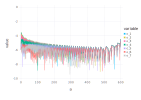

In [19]:
agrid = LinRange(HH.a̲,HH.a̅,1000)
df_ee,EEmax = ee_errors(HH,agrid)
println(EEmax)
plot(stack(df_ee,["ϵ_$s" for s in 1:HH.Nϵ]),x=:a,y=:value,color=:variable,Geom.line)

# Aiyagari Model
## Production
* Production is produced by a representative firm endowed with a CRS production function $F(K,N)$
    * hires effective labor from HH at a wage rate $\bar W$
    * hires capital from HH at rental rate $\bar r + \delta$
    * Usually $F(K,N) = \Theta K^\alpha N^{1-\alpha}$

* No arbitrage conditions imply that 
\begin{align}
    w &= F_N(K,N)
    r &= F_K(K,N) - \delta
\end{align}

* Household savings therefore pay a gross interest rate $R=1+r$

* Focus on steady sate: capital stock, and therefore prices, constant over time
    * Need to find stationary distirbution of HH

## Stationary Distribution
* Consider the behavior of agents under the policy rules $a'(a,s)$ and transition matrix $\Pi(s,s')$

* Let $\lambda_t$ describe the current distribution of agents
    * $\lambda_t(a,s)$ is the fraction of agents with productivity $\epsilon_s$ and assets less than or equal to $a$
    * more generally $\lambda_t$ could be a measure

* Under the stationary policy rules $a'(a,s)$, $\lambda_t$ evolves according to 
$$
    \lambda_{t+1}(a',s') = \sum_s \Pi(s,s')\int\iota(a'(a,s)\leq a')\lambda_t(da,s)
$$
where $\iota(a'(a,s)\leq a')$ is an indicator which is 1 if $a'(a,s)\leq a'$ and 0 overwise.

* Our equilibrium concept will use the distribution $\lambda$ which is stationary under $a'(a,s)$


## Stationary Recursive Equilibrium 
A *Stationary Recursive Equilibrium* is a set of prices $r,w$; a value function and policy rules $v(a,s),c(a,s),$ and $a'(a,s)$;
aggregates $K$ and $N$; and a stationary distrubtion $\lambda$ such that

1. Given prices the value function and policy rules solve the HH's Bellman equation

2. $r$,$w$ satisfy the no-arbitrage condition of the firm

3. The distribution is stationary under $a'(a,s)$ and $\Pi(s,s')$
$$
\lambda(a',s') = \sum_s \Pi(s,s')\int\iota(a'(a,s)\leq a')\lambda(da,s)
$$

4. The labor market clears
$$
    N = \sum_s\int \epsilon_s \lambda(da,s)
$$

5. The asset market clears
$$
    K = \sum_s\int a \lambda(da,s)
$$

## Computing the Stationary Distribution
* We want to know how to compute a stationary recursive equilibrium.
    * For that we need to know how to compute $\lambda$

* Construct a set of $Na$ grid points $\hat a_i$ 
    * Generally will be much larger number than nodes used for interpolation

* Let $\omega_{i,s}^t$ be the fraction of agents who have productivity $\epsilon_s$ and assets $\hat a_i$
    
* Want: a way to compute $\omega_{i,s}^{t+1}$ and stationary distribution $\bar \omega_{i,s}$

* For a given $i,s$, compute $a'(\hat a_i,s)$
    * won't be exactly on grid points
    * assign to neighboring gridpoints with probabilities

* Let $Q_a(\hat a_i,s,\hat a_{i'})$ be the fraction of agents with assets $\hat a_i$ and productivity $\epsilon_s$ who transition to gridpoint $\hat a_{i'}$
$$
    Q_a(\hat a_i,s_i,\hat a_{i'}) = \mathbf 1_{a'(\hat a_i,s)\in[\hat a_{i'-1},\hat a_{i'}]}\frac{a'(\hat a_i,s)-\hat a_{i'}}{\hat a_{i'} -\hat a_{i'-1}} + \mathbf 1_{a'(\hat a_i,s)\in[\hat a_{i'},\hat a_{i'+1}]}\frac{\hat a_{i'+1}-a'(\hat a_i,s)}{\hat a_{i'+1} -\hat a_{i'}}
$$

## Computing the Stationary Distribution Cont.
* Key property: $Q$ maintains the average level of debt
$$
    \sum_j Q_a(\hat a_i,s_i,\hat a_{i'})\hat a_{i'} = a'(\hat a_i,s) 
$$

* Convenient property, elements of $Q_a$ look like B-splines of order 1
    * $Q_a$ can be constructed by evaluating order 1 B-Splines with knots at $\hat a_i$
    * Basis functions evaluated at the points $a'(a_i,s)$

* Once $Q_a$ is constructed the probability of transitioning from $(\hat a_i,s)$ to $(\hat a_{i'},s')$ is 
$$
    Q(\hat a_i,s,\hat a_{i'},s') = Q_a(\hat a_i,s_i,\hat a_{i'})\Pi(s,s')
$$

* Will often stack gridpoints $(\hat a_i,s)$ into one long matrix $\bar z$ with row $\bar z_j$ being one state
    * Can reinterpret $Q(j,j')$

* Compute stationary distribution by computing unit eigenvector of $Q'$


## Aiyagari Model struct

In [20]:
@with_kw mutable struct AiyagariModel
    HH::HHModel = HHModel()

    #Production Parameters
    α::Float64 = 0.3
    δ::Float64 = 0.025
    Θ̄::Float64 = 1.

    #Moments to match/prices
    W̄::Float64 = 1.
    R̄::Float64 = 1.01
    K2Y::Float64 = 10.2 #capital to output ratio
    N̄::Float64 = 1.

    #Distribution Parameters
    Ia::Int = 1000 #Number of gridpoints for distribution
    z̄::Matrix{Float64} = zeros(0,0) #Gridpoints for the state variables
    ω̄::Vector{Float64} = zeros(0) #Fraction of agents at each grid level
    H::SparseMatrixCSC{Float64,Int64} = spzeros(Ia,Ia) #Transition matrix
end;

## Setup

In [21]:
"""
    setupgrids_shocks!(AM::AiyagariModel)

Setup the grids and shocks for the aiyagari model
"""
function setupgrids_shocks!(AM::AiyagariModel,curv=2.)
    @unpack HH,Ia,N̄= AM
    @unpack a̲,a̅,Nϵ = HH
    setupgrids_shocks!(HH)
    #Normalize so that average labor supply is 1
    πstat = real(eigs(HH.Π',nev=1)[2])
    πstat ./= sum(πstat)
    HH.ϵ = HH.ϵ./dot(πstat,HH.ϵ)*N̄
    #Grid for distribution
    agrid = (a̅-a̲).*LinRange(0,1,Ia).^curv .+ a̲
    AM.z̄ = hcat(kron(ones(Nϵ),agrid),kron(1:Nϵ,ones(Ia)))
    AM.ω̄ = ones(Ia*Nϵ)/(Ia*Nϵ)
end;

## Computing Stationary Distribution

In [22]:
"""
    find_stationarydistribution!(AM::AiyagariModel,V)

Computes the stationary distribution 
"""
function find_stationarydistribution!(AM::AiyagariModel)
    @unpack Ia,z̄,HH,W̄,R̄ = AM
    @unpack ϵ,Π,Nϵ,cf,a̲,a̅ = HH

    a = z̄[1:Ia,1] #grids are all the same for all shocks
    c = hcat([cf[s](a) for s in 1:Nϵ]...) #consumption policy IaxNϵ
    a′ = R̄.*a .+ W̄.*ϵ' .- c #create a IaxNϵ grid for the policy rules
    
    #make sure we don't go beyond bounds.  Shouldn't bind if bmax is correct
    a′ = max.(min.(a′,a̅),a̲)
    
    Qa = BasisMatrix(Basis(SplineParams(a,0,1)),Direct(),reshape(a′,Ia*Nϵ)).vals[1]
    Q = spzeros(Ia*Nϵ,Ia*Nϵ)
    for s in 1:Nϵ
        Q[1+(s-1)*Ia:s*Ia,:] = kron(reshape(Π[s,:],1,:),Qa[1+(s-1)*Ia:s*Ia,:]) 
    end
    
    AM.H = Q'
    AM.ω̄ .= real(eigs(AM.H;nev=1)[2])[:]
    AM.ω̄ ./= sum(AM.ω̄) #normalize eigenvector
end;

## Capital Supply and Demand
* Given an interest rate $R$ can compute steady state supply and demand for capital

* $N$ is fixed at steady state, steady state demand is pinned down by
$$
    R = 1 - \delta + F_K(K,N)
$$

* Steady state wage then satisfies $W = F_N(K,N)$

* Compute agent policies given $R,W$: $a'(a,s)$

* Find steady state that results from those policies
    * aggregate to compute asset supply

## Computing asset market supply and demand

In [23]:
"""
    capital_supply_demand(AM,R)

Compute the supply and demand for capital which prevails in
the stationary distribution at a given interest rate.
"""
function capital_supply_demand(AM,R)
    @unpack Θ̄,α,N̄,δ = AM
    AM.R̄ = R
    AM.HH.r̄ = R-1

    Y2K = (R-1+δ)/α
    K2N = (Y2K/Θ̄)^(1/(α-1))
    AM.W̄ = AM.HH.w̄ = (1-α)*Θ̄*K2N^α
    KD = K2N * N̄ 

    solvebellman!(AM.HH)
    find_stationarydistribution!(AM)
    KS = dot(AM.ω̄,AM.z̄[:,1])

    return [KS,KD]
end;

## Plotting Supply and Demand Curves

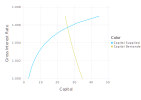

In [24]:
AM = AiyagariModel()
AM.HH.β = 0.99
setupgrids_shocks!(AM)

Rgrid = LinRange(1.,1.007,10)
KSKD = hcat([capital_supply_demand(AM,R) for R in Rgrid]...)
plot(layer(y=Rgrid,x=KSKD[1,:],color=["Capital Supplied"],Geom.line),
     layer(y=Rgrid,x=KSKD[2,:],color=["Capital Demanded"],Geom.line),
     Guide.ylabel("Gross Interest Rate"), Guide.xlabel("Capital"))

## Calibrating
* Often we calibrate by targeting a particular interest rate
    * say 1% quarterly

* Adjust $\beta$ to target that interest rate in stationary distribution

In [25]:
AM.R̄ = 1.01 #target a quarterly interest rate of 1%
function calibratesteadystate!(AM)
    @unpack Θ̄,α,N̄,K2Y,R̄ = AM
    AM.HH.r̄ = R̄ - 1
    Y2K = 1/K2Y
    AM.δ = α*Y2K + 1 - R̄ #matching capital to output ratio and interest rate gives depreciation rate
    K2N = (Y2K/Θ̄)^(1/(α-1)) #relationship between capital to output and capital to labor
    K̄ = K2N*N̄
    AM.W̄ = AM.HH.w̄ = (1-α)*Θ̄*K2N^α

    setupgrids_shocks!(AM)
    function βres(β)
        AM.HH.β=β
        solvebellman!(AM.HH)
        find_stationarydistribution!(AM)
        return dot(AM.ω̄,AM.z̄[:,1]) -K̄
    end

    Q̄ = 1/R̄
    fzero(βres,Q̄^2,Q̄^1.2)
end
AM = AiyagariModel()
calibratesteadystate!(AM)

0.9860523246505593

## Stationary Distribution in Steady state

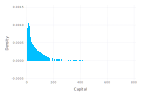

In [26]:
plot(x=AM.z̄[AM.z̄[:,1].>1.,1],y=AM.ω̄[AM.z̄[:,1].>1.],Geom.bar,
    Guide.xlabel("Capital"), Guide.ylabel("Density"))